# Spiking time dependent plasticity & Phase procession in hippocampus
## Model 1: Muller et al 2003, _Frontiers in computational neuroscience_
The model applied STDP learning rule to integrate-and-fire neurons which are phase locked at different values. All neurons have the same spiking phase after learning. <br>
**Integrate-and-fire neurons**: <br> 
$$ \tau_m\frac{dV}{dt} = (V_R-V)+g_e(E_e-V_R) + R_mI $$ $V_R=-70mV$: resting potential; $E_e=0mV$: reversal potential for an excitatory synapse. <br>
When a presynaptic spike occurs, $g_e \rightarrow g_e + w$. The locked phase depends on the input current $I$. <br>
**STDP**: <br>
$$f(s) = A_+e^{\frac{-s}{\tau_+}} (s>0), \quad f(s) = -A_-e^{\frac{s}{\tau_-}} (s<0)$$
### Theoretical Proof:
Presynaptic imhomogenous Possion input rate: $I(t)=\frac{r}{c+1}[c-cos(vt)]$ <br>
Postsynaptic spike train (phase locked): $S(t)=\sum_n\delta(t - \frac{2\pi n+\phi}{v}), \quad \phi \propto I$ (input current) <br>
Correlation between input oscillation and postsynaptic spike train: $C(s) = \frac{vr}{2\pi(c+1)} \int_{-\infty}^{\infty}[c-cos(vt)]\delta(t+s-\frac{\phi}{v})dt $ <br>
**The dynamics of synaptic weight change over time:**
$$ \frac{dw}{dt} = w_{max}\int_{-\infty}^{\infty} f(s)C(s)ds $$ The steady states of w depends on the parameters selected but are the same for all the neurons.


### Numerical Simulations
#### Lyle's original code from ModelDB, using Brian 1 (code not working!)

In [31]:
from brian import *
import multiprocessing
import numpy as np

### PARAMETERS
N=5000
M=10
taum=33*ms                          
tau_pre=20*ms
tau_post=tau_pre
Ee=0*mV
vt=-54*mV
vr=-70*mV
El=-70*mV
taue=5*ms
f=20*Hz
theta_period = 1/f
Rm=200*Mohm
a = linspace(51,65,num=M)       
weights = .001
ratio=1.50
dA_pre=.01
dA_post=.01*ratio 
trials=10

### SIMULATION LOOP
eqs_neurons='''
dv/dt=((ge*(Ee-vr))+Rm*I+(El-v))/taum : volt   
dge/dt=-ge/taue : 1
I : amp
'''

inputs = PoissonGroup(N,rates=lambda t:((.5-.5*cos(2*pi*f*t)))*10*Hz)           
neurons=NeuronGroup(M,model=eqs_neurons,threshold=vt,reset=vr)
neurons.I = a*pA
synapses=Connection(inputs,neurons,'ge',weight=weights)
neurons.v=vr

S = SpikeMonitor(neurons)
run(2*second)
stdp=ExponentialSTDP(synapses,tau_pre,tau_post,dA_pre,-dA_post,wmax=10*weights,interactions='all',update='additive')     
run(5*second)


phase=zeros((M,200))
for b in range(0,M):    
    tmp_phase=(S[b]%theta_period)*(360/theta_period)
    phase[b,range(0,len(tmp_phase))] = tmp_phase




TypeError: object of type 'Connection' has no len()

#### Brian2 code 
Added pulse input

(69900, 75000)

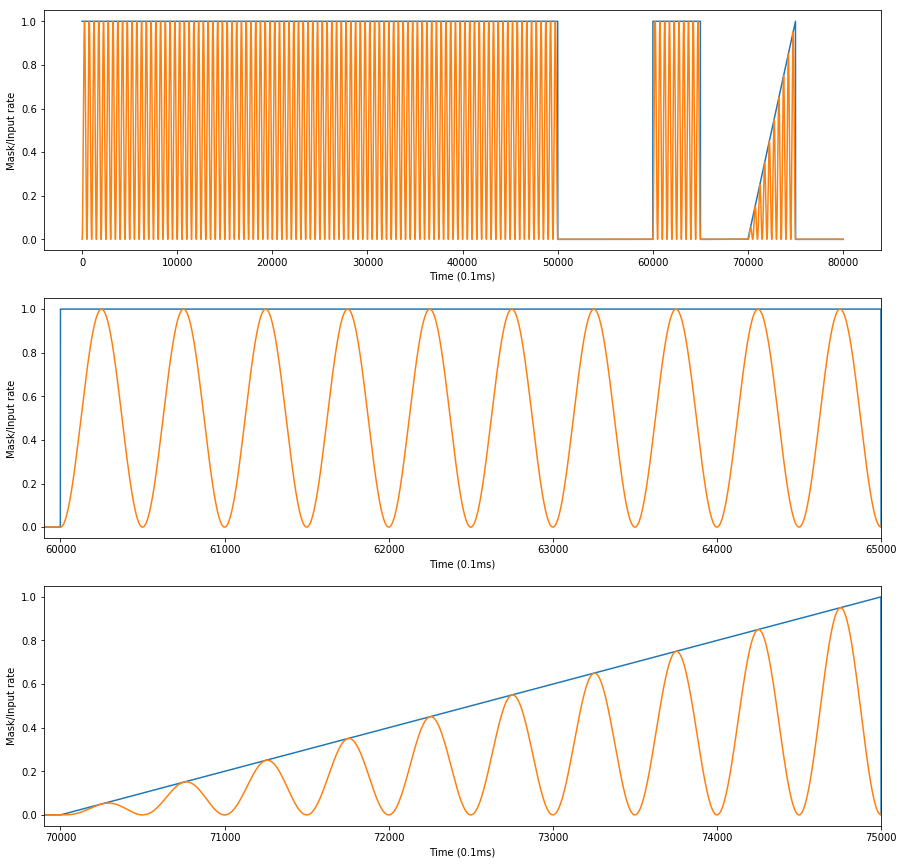

In [2]:
### IMPORTS
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
%matplotlib inline


### PARAMETERS
start_scope()

N=5000
M=10
taum=33*ms                          
taupre=20*ms
taupost=taupre
Ee=0*mV
vt=-54*mV
vr=-70*mV
El=-70*mV
taue=5*ms
f=20*Hz
theta_period = 1/f
Rm=200*Mohm
a = linspace(51,65,num=M)       
weights = .001
weights_max = 10*weights
ratio=1.7
Apre=.01*weights_max
Apost=-Apre*ratio 
trials=10

# Simulation begins
# General settings: input, neurons
eqs_neurons='''
dv/dt=((ge*(Ee-vr))+Rm*I+(El-v))/taum : volt   
dge/dt=-ge/taue : 1
I : amp
'''


tend = 8 # seconds
time_range = np.arange(0,tend,1e-4)*second
tmp = (.5-.5*cos(2*pi*f*time_range))
fr = np.ones((int(8*1e4),))
fr[int((tend-3)*1e4):int(tend*1e4)] = 0
fr[int((tend-2)*1e4):int((tend-1.5)*1e4)] = 1
fr[int((tend-1)*1e4):int((tend-0.5)*1e4)] = np.arange(0,10000,2)*1e-4
tmp_fr = tmp*fr

figure(figsize=(15,15))
subplot(311)
plot(fr)
plot(tmp_fr/second)
ylabel('Mask/Input rate')
xlabel('Time (0.1ms)')
subplot(312)
plot(fr)
plot(tmp_fr/second)
ylabel('Mask/Input rate')
xlabel('Time (0.1ms)')
xlim(60000-100,65000)
subplot(313)
plot(fr)
plot(tmp_fr/second)
ylabel('Mask/Input rate')
xlabel('Time (0.1ms)')
xlim(70000-100,75000)


In [3]:
rate_in = TimedArray(tmp_fr*10*Hz, dt=defaultclock.dt) #c=1
inputs = PoissonGroup(N,rates='rate_in(t)')           
neurons = NeuronGroup(M,model=eqs_neurons,threshold='v>vt',reset='v=vr')
neurons.I = a*pA
neurons.v=vr


# Synapse connection 
Syn = Synapses(inputs,neurons, on_pre = 'ge += weights')
Syn.connect()

syn_stdp = Synapses(inputs, neurons, model='''
                w:1
                dapre/dt = -apre/taupre : 1 (clock-driven)
                dapost/dt = -apost/taupost : 1 (clock-driven)''',
                on_pre='''ge += w
                       apre += Apre
                       w = clip(w + apost, 0, weights_max)''',
                on_post='''apost += Apost
                        w = clip(w + apre, 0, weights_max)''') 
syn_stdp.connect()
syn_stdp.w = weights

S = SpikeMonitor(neurons)
Nmon = StateMonitor(neurons,variables='v',record=True)
# It is very easy to crash if record parameters from synapses
Smon = StateMonitor(Syn,'ge',record=range(1))
Smon_stdp = StateMonitor(syn_stdp,['w', 'apre', 'apost'], record=range(1))
Imon = SpikeMonitor(inputs)

net = Network(inputs,neurons,Syn,S,Nmon,Smon,Imon)
net.run(2*second)
net.remove(Syn,Smon)
net.add(syn_stdp,Smon_stdp)
net.run((tend-2)*second)

creating /tmp/scipy-yuchen-jHgrJD/python27_intermediate/compiler_29ba3733ba64ac31076a2b0d0aed9552


INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 1.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.40s). [brian2.stateupdaters.base.method_choice]


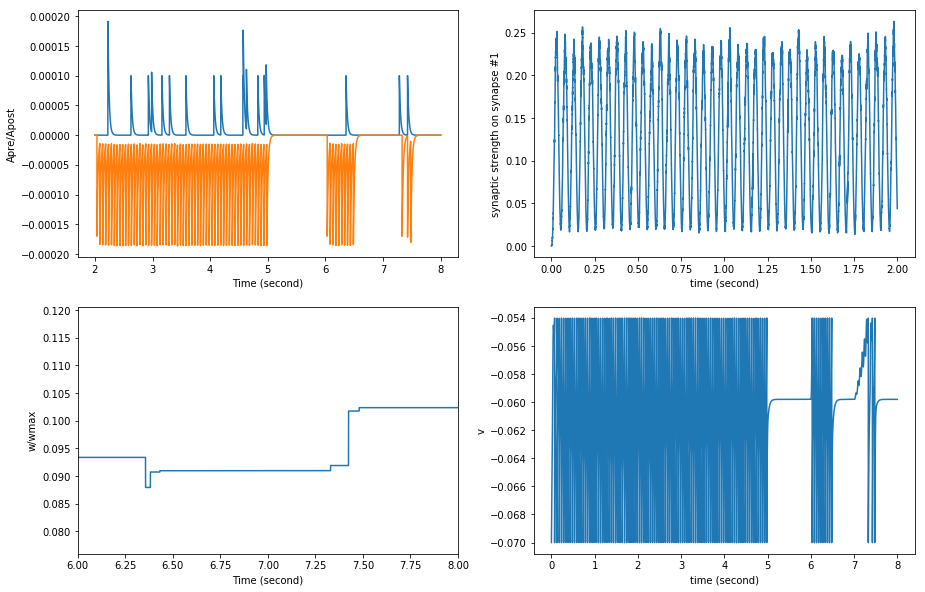

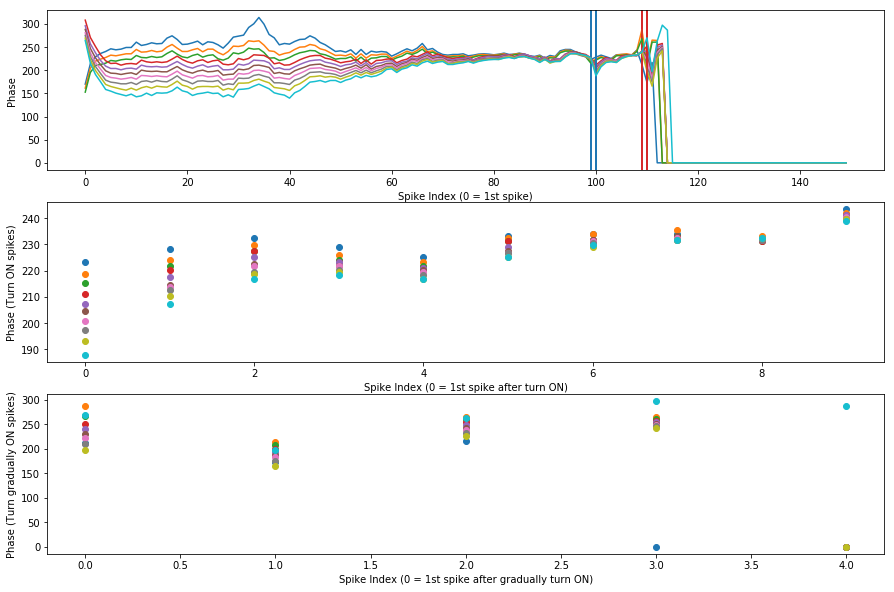

In [230]:
# Smon_stdp.apre[0]
figure(figsize=(15, 10))
subplot(221)
plot(Smon_stdp.t, Smon_stdp.apre[0], label='apre')
plot(Smon_stdp.t, Smon_stdp.apost[0],label='apost')
ylabel('Apre/Apost')
xlabel('Time (second)')
subplot(223)
plot(Smon_stdp.t, Smon_stdp.w[0]/weights_max,label='w/wmax')
ylabel('w/wmax')
xlabel('Time (second)')
#xlim(6,8)
subplot(222)
plot(Smon.t, Smon.ge[0])
xlabel('time (second)')
ylabel('synaptic strength on synapse #1')
subplot(224)
plot(Nmon.t, Nmon.v[0].T)
xlabel('time (second)')
ylabel('v')


# Plotting the phase of spike
figure(figsize=(15, 10))
subplot(311)
S_all = S.all_values()
S_t = S_all['t']
phase = zeros((M,1500))
idxs = zeros((M,3))
for i in range(M):
    tmp = sort(S_t[i]) % theta_period * (360/theta_period)
    idxs[i,0] = np.arange(len(S_t[i]))[sort(S_t[i])>(tend-2)*second][0] # spike idx of turn ON
    idxs[i,1] = len(tmp) # spike end idx
    idxs[i,2] = np.arange(len(S_t[i]))[sort(S_t[i])>(tend-1)*second][0] # spike idx of turn gradually on 
    axvline(x=idxs[i,0],color='#1f77b4')
    axvline(x=idxs[i,2],color='#d62728')
    phase[i,range(int(idxs[i,1]))] = tmp
    plot(phase[i,0:150])
    ylabel('Phase')
    xlabel('Spike Index (0 = 1st spike)')
subplot(312)
for i in range(M):
    rg = np.arange(int(idxs[i,0]),int(idxs[i,0])+10)
    plot(phase[i,rg],'o')
    ylabel('Phase (Turn ON spikes)')
    xlabel('Spike Index (0 = 1st spike after turn ON)')
subplot(313)
for i in range(M):
    rg2 = np.arange(int(idxs[i,2]),int(idxs[i,2])+5)
    plot(phase[i,rg2],'o')
    ylabel('Phase (Turn gradually ON spikes)')
    xlabel('Spike Index (0 = 1st spike after gradually turn ON)')

# print(idxs)
# subplot(212)
# for i in range(M):
#     tmp = sort(S_t[i])
#     S_t_ON = tmp[tmp>6*second]
#     phase_ON = S_t_ON % theta_period * (360/theta_period)
#     plot(phase_ON)
    

### Modified version 1: Replace with adaptive integrate-and-fire neurons
**Adpative integrate-and-fire model:** <br>
$$ C\frac{dV}{dt} = -g_L(V-V_r) + g_L\Delta_T exp(\frac{V-V_T}{\Delta_T}) - w +I + g_e(E_e-V_r) $$ <br>
$$ \tau_w \frac{dw}{dt} = a(V-V_r) - w $$ <br>
where $w$ is adaptation variable; $I$ is input current; $C$ the membrane capacitance; $g_L$ leak conductance; $V_r$ resting potential; $E_e$ reversal potential for an excitatory synapse; $V_T$ the threshold, maximum voltage which could be reached without generating a spike under constant current injection; $\Delta_T$ the slope factor towards threshold,sharpness of the spike ($\Delta_T=0$ is normal integrate-and-fire neuron); $a$ the voltage adpatation coupling factor. <br>
Upon spikeing, reset $V \rightarrow V_r$ and $w\rightarrow w+b$.


In [218]:
from brian2 import *

start_scope()

# Parameters
# AdEx related
C = 281 * pF
gL = 30 * nS
taun = C / gL
Vr = -70.6 * mV
VT = -50.4 * mV
DeltaT = 2 * mV
DeltaT = 0 * mV
Vcut = VT + 5 * DeltaT #threshold to fire
Ee=0*mV
# Pick an electrophysiological behaviour
tauw, a, b, Vr = 144*ms, 4*nS, 0.0805*nA, -70.6*mV # Regular spiking (as in the paper)
#tauw,a,b,Vr=20*ms,4*nS,0.5*nA,VT+5*mV # Bursting
#tauw,a,b,Vr=144*ms,2*C/(144*ms),0*nA,-70.6*mV # Fast spiking

# Synaptic parameters (normal&STDP)
N=5000
M=10                        
taupre=20*ms
taupost=taupre
taue=5*ms # decay of synaptic strength
weights = .001/3
weights_max = 10*weights
ratio=1.7
Apre=.01*weights_max
Apost=-Apre*ratio 
# input related
f=20*Hz
theta_period = 1/f
a_in = linspace(780,820,num=M) # above parameter spike at 1nA

# Inputs
tend = 8 # seconds
time_range = np.arange(0,tend,1e-4)*second
tmp = (.5-.5*cos(2*pi*f*time_range))
fr = np.ones((int(8*1e4),))
fr[int((tend-3)*1e4):int(tend*1e4)] = 0
fr[int((tend-2)*1e4):int((tend-1.5)*1e4)] = 1
fr[int((tend-1)*1e4):int((tend-0.5)*1e4)] = np.arange(0,10000,2)*1e-4
tmp_fr = tmp*fr
rate_in = TimedArray(tmp_fr*10*Hz, dt=defaultclock.dt) 
inputs = PoissonGroup(N,rates='rate_in(t)') 

# Neurons
eqs_neurons = """
dVm/dt = (gL*(Vr - Vm) + gL*DeltaT*exp((Vm - VT)/DeltaT) + I - w + ge*gL*(Ee-Vr))/C  : volt
dw/dt = (a*(Vm - Vr) - w)/tauw : amp
dge/dt=-ge/taue : 1
I : amp
"""
neurons = NeuronGroup(M,model=eqs_neurons,threshold='Vm>Vcut',reset='Vm=Vr;w+=b',method='euler')
neurons.I = a_in*pA
neurons.Vm = Vr
trace = StateMonitor(neurons, 'Vm', record=0)
spikes = SpikeMonitor(neurons)

# Synapses
Syn = Synapses(inputs,neurons, on_pre = 'ge += weights')
Syn.connect()
Syn_stdp = Synapses(inputs, neurons, model='''
                w_s:1
                dapre/dt = -apre/taupre : 1 (clock-driven)
                dapost/dt = -apost/taupost : 1 (clock-driven)''',
                on_pre='''ge += w_s
                       apre += Apre
                       w_s = clip(w_s + apost, 0, weights_max)''',
                on_post='''apost += Apost
                        w_s = clip(w_s + apre, 0, weights_max)''') 
Syn_stdp.connect()
Syn_stdp.w_s = weights
Smon = StateMonitor(Syn,'ge',record=range(1))
Smon_stdp = StateMonitor(Syn_stdp,['w', 'apre', 'apost'], record=range(1))



net2 = Network(inputs,neurons,Syn,trace,spikes,Smon)
net2.run(2*second)
net2.remove(Syn,Smon)
net2.add(Syn_stdp,Smon_stdp)
net2.run((tend-2)*second)

WARNING    "t" is an internal variable of group "synapses_5", but also exists in the run namespace with the value 1.9877 * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'synapses_6', using method 'exact' (took 0.31s). [brian2.stateupdaters.base.method_choice]
WARNING    "t" is an internal variable of group "synapses_6", but also exists in the run namespace with the value 1.9877 * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0,0.5,'membrane potential (mV)')

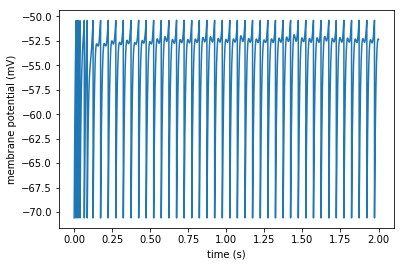

In [195]:
Vm = trace[0].Vm[:]
plot(trace.t / second, Vm / mV)
xlabel('time (s)')
ylabel('membrane potential (mV)')

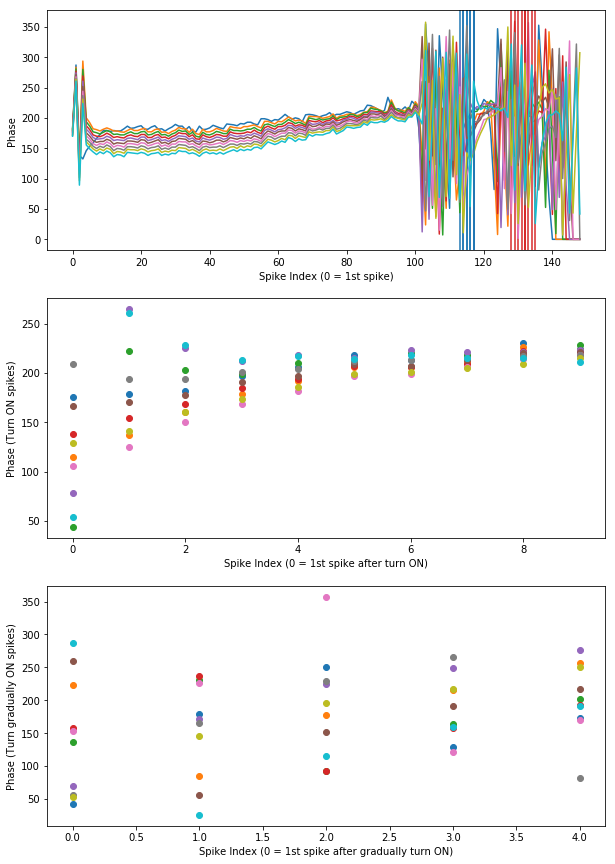

In [224]:
figure(figsize=(10, 15))
subplot(311)
phase = zeros((M,500))
S_t = spikes.all_values()
S_t = S_t['t']
idxs = zeros((M,3))
for i in range(M):
    tmp = sort(S_t[i]) % theta_period * (360/theta_period)
    idxs[i,0] = np.arange(len(S_t[i]))[sort(S_t[i])>(tend-2)*second][0] # spike idx of turn ON
    idxs[i,1] = len(tmp) # spike end idx
    idxs[i,2] = np.arange(len(S_t[i]))[sort(S_t[i])>(tend-1)*second][0] # spike idx of turn gradually on 
    axvline(x=idxs[i,0],color='#1f77b4')
    axvline(x=idxs[i,2],color='#d62728')
    phase[i,range(len(tmp))] = tmp
    plot(phase[i,1:150])
    ylabel('Phase')
    xlabel('Spike Index (0 = 1st spike)')
    
subplot(312)
for i in range(M):
    rg = np.arange(int(idxs[i,0]),int(idxs[i,0])+10)
    plot(phase[i,rg],'o')
    ylabel('Phase (Turn ON spikes)')
    xlabel('Spike Index (0 = 1st spike after turn ON)')
subplot(313)
for i in range(M):
    rg2 = np.arange(int(idxs[i,2]),int(idxs[i,2])+5)
    plot(phase[i,rg2],'o')
    ylabel('Phase (Turn gradually ON spikes)')
    xlabel('Spike Index (0 = 1st spike after gradually turn ON)')


In [191]:
phase[8]


array([ 49.68, 102.96, 157.68, 213.84, 277.2 ,   0.72, 100.08, 186.48,
       279.36,  73.44, 190.08, 315.36, 133.2 , 249.12,  90.  , 209.52,
        24.48, 175.68, 306.72, 134.64, 255.6 , 105.84, 225.36,  69.84,
       194.4 , 354.96, 157.68, 282.96, 119.52, 239.76,  90.72, 215.28,
        52.56, 187.2 , 331.2 , 146.88, 270.72, 113.04, 232.56,  81.36,
       205.92,  26.64, 171.36, 297.36, 128.88, 248.4 ,  99.36, 222.48,
        68.4 , 195.84, 344.16, 151.92, 277.92, 120.96, 239.76,  87.84,
       210.24,  33.12, 180.  , 308.16, 135.36, 253.44, 103.68, 227.52,
        72.  , 195.84,   1.44, 162.72, 287.28, 121.68, 239.04,  90.72,
       211.68,  43.92, 185.04, 319.68, 139.68, 260.64, 108.72, 228.24,
        74.88, 201.6 ,   8.64, 166.32, 295.2 , 131.04, 250.56,  95.76,
       221.76,  62.64, 192.24, 344.16, 149.76, 268.56, 113.76, 233.28,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
      